In [75]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as Data

In [88]:
#parameters
epochs = 500
timesteps = seq_length = 7  #7일치 data를 예측에 사용
input_size = 5  #하루에 담고 있는 데이터의 종류가 5개 (open, high, low, close, volume)
num_classes = 1  #최종 output은 close 하나
hidden_size = 5
num_layers = 1

xy = np.loadtxt('data-02-stock_daily.csv', delimiter = ',')
xy = xy[::-1]  #reverse order (chronically ordered)

def MinMaxScaler(data):
    numerator = data - np.min(data, 0) #column별로 가장 작은 값을 data에서 빼줌 (min을 0으로!)
    denominator = np.max(data,0) - np.min(data,0) #컬럼별로 가장 큰 값에서 가장 작은 값 빼준 값
    #noise term prevents the zero division
    return numerator / (denominator + 1e-7)    
    
    
xy = MinMaxScaler(xy)
x = xy  #전체 data가 최소 한 번은 x값이 된다. (time series)
y = xy[:,[-1]]  #Close as label  

In [83]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i+seq_length]
    _y = y[i+seq_length] #Next close price
    print(_x, '->', _y)
    dataX.append(_x)
    dataY.append(_y)

[[2.13751054e-01 2.08179810e-01 1.91791832e-01 4.66075110e-04
  1.92092403e-01]
 [1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.36419163e-01 1.62682724e-01 5.70171193e-01
  1.47442742e-01]] -> [0.13289962]
[[1.93935034e-01 2.03641926e-01 2.08664571e-01 2.98467330e-03
  1.96551555e-01]
 [2.10516454e-01 2.05289413e-01 2.03558748e-01 2.59926504e-04
  1.87749731e-01]
 [1.86678765e-01 2.09480567e-01 2.08781843e-01 0.00000000e+00
  2.17448151e-01]
 [3.06973882e-01 3.14634137e-01 2.18993665e-01 1.24764722e-02
  2.16981885e-01]
 [2.19142110e-01 2.63907214e-01 2.24686396e-01 4.56323384e-01
  2.24967473e-01]
 [2.33129931e-01 2.3641

 [0.3688325  0.37731918 0.3581049  0.15185086 0.35022302]] -> [0.37537475]
[[0.31387239 0.33783609 0.31262205 0.33111051 0.30671028]
 [0.3232851  0.34211402 0.32908404 0.23014251 0.35494459]
 [0.35653503 0.3576355  0.33821278 0.15700457 0.3313666 ]
 [0.30699513 0.31069511 0.31599665 0.18652864 0.31519143]
 [0.34339236 0.34780804 0.34202457 0.20360312 0.35587706]
 [0.3688325  0.37731918 0.3581049  0.15185086 0.35022302]
 [0.34516993 0.37049768 0.36347486 0.17006364 0.37537475]] -> [0.38825675]
[[0.3232851  0.34211402 0.32908404 0.23014251 0.35494459]
 [0.35653503 0.3576355  0.33821278 0.15700457 0.3313666 ]
 [0.30699513 0.31069511 0.31599665 0.18652864 0.31519143]
 [0.34339236 0.34780804 0.34202457 0.20360312 0.35587706]
 [0.3688325  0.37731918 0.3581049  0.15185086 0.35022302]
 [0.34516993 0.37049768 0.36347486 0.17006364 0.37537475]
 [0.36454884 0.37518031 0.38105175 0.12239849 0.38825675]] -> [0.3808831]
[[0.35653503 0.3576355  0.33821278 0.15700457 0.3313666 ]
 [0.30699513 0.3106951

 [0.78630815 0.7811092  0.78711094 0.12432554 0.77856004]] -> [0.78672046]
[[0.81244782 0.82671994 0.83171352 0.12860984 0.83798574]
 [0.83153522 0.82882988 0.84697231 0.0793941  0.83877253]
 [0.8274264  0.82195069 0.83928426 0.1131487  0.82411293]
 [0.80268544 0.80141439 0.79843759 0.16828897 0.77847252]
 [0.75906128 0.79287318 0.7818291  0.11679663 0.80575192]
 [0.78630815 0.7811092  0.78711094 0.12432554 0.77856004]
 [0.77211644 0.78532926 0.79682372 0.0967554  0.78672046]] -> [0.81373749]
[[0.83153522 0.82882988 0.84697231 0.0793941  0.83877253]
 [0.8274264  0.82195069 0.83928426 0.1131487  0.82411293]
 [0.80268544 0.80141439 0.79843759 0.16828897 0.77847252]
 [0.75906128 0.79287318 0.7818291  0.11679663 0.80575192]
 [0.78630815 0.7811092  0.78711094 0.12432554 0.77856004]
 [0.77211644 0.78532926 0.79682372 0.0967554  0.78672046]
 [0.78167481 0.80301855 0.79931805 0.11626781 0.81373749]] -> [0.80534385]
[[0.8274264  0.82195069 0.83928426 0.1131487  0.82411293]
 [0.80268544 0.801414

### Training and test datasets

In [84]:
#split to train and testing
train_size = int(len(dataY)*0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

trainX = Variable(torch.tensor(trainX)).float()
trainY = Variable(torch.tensor(trainY)).float()
testX = Variable(torch.tensor(testX)).float()

### LSTM and Loss

In [85]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_len):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.lr = 0.01
        
        #nn.LSTM: Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.
        #True: inputs are (batch_size, sequence_length, input_dimension)c
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_size,
                           num_layers = self.num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)
    
    def forward(self, x):
        #If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).float()
        
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).float()
        _ ,(h_out,_) = self.lstm(x, (h_0, c_0))  #use only last value (result = next day after 7 days)
        # Note: the output tensor of LSTM in this case is a block with holes
        # > add .contiguous() to apply view()
        h_out = h_out.contiguous().view(-1, hidden_size)
        out = self.fc(h_out)
        return out
    
    def train_(self,train_X, train_Y):
        self.optimizer.zero_grad()
        outputs = self.forward(train_X)
        self.cost = self.criterion(outputs, train_Y)
        self.cost.backward()
        self.optimizer.step()
        return self.cost
        

In [95]:
model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)
model

# Train the model
for epoch in range(1, epochs + 1):
    cost = model.train_(trainX, trainY)
    if epoch % 25 == 0:
        print('Epoch: {}, cost: {:1.5f}'.format(epoch,cost))

print("Learning finished!")

Epoch: 25, cost: 0.01243
Epoch: 50, cost: 0.00213
Epoch: 75, cost: 0.00179
Epoch: 100, cost: 0.00162
Epoch: 125, cost: 0.00150
Epoch: 150, cost: 0.00141
Epoch: 175, cost: 0.00134
Epoch: 200, cost: 0.00128
Epoch: 225, cost: 0.00124
Epoch: 250, cost: 0.00119
Epoch: 275, cost: 0.00116
Epoch: 300, cost: 0.00112
Epoch: 325, cost: 0.00109
Epoch: 350, cost: 0.00106
Epoch: 375, cost: 0.00104
Epoch: 400, cost: 0.00102
Epoch: 425, cost: 0.00100
Epoch: 450, cost: 0.00098
Epoch: 475, cost: 0.00096
Epoch: 500, cost: 0.00094
Learning finished!


Text(0,0.5,'Stock Price')

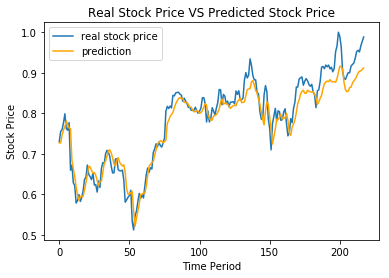

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

# Test the model
model.eval()
test_predict = model.forward(testX)
test_predict = test_predict.data.numpy()
testY = np.array(testY)

plt.plot(testY, label = 'real stock price')
plt.plot(test_predict, color = 'orange', label = 'prediction')
plt.legend()
plt.title('Real Stock Price VS Predicted Stock Price')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")